# Trajectory Analysis

In [144]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from matplotlib import collections  as mc

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.utils import resample

from scipy.stats import mode

import os



colnames = ['X','Z','perimeter','realSurfacePerimeter','occlusionValue','area','mean','variance','skewness','circularity_ben','circularity','centroid_x','centroid_z','inDoor']
data = pandas.read_csv('trajectories.csv', names=colnames)



/Users/thanh/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [145]:
x = data.X.tolist()
y = data.Z.tolist()

print(len(x))
print(len(y))
print(len(data))

1254774
1254774
1254774


In [146]:
'''
def createJson():
    file_object  = open("trajectory.txt", "w") 
    params ='{"epsilon": 0.016, "min_neighbors": 2, "min_num_trajectories_in_cluster": 30, "min_vertical_lines": 2, "min_prev_dist": 0.002, "trajectories": '
    trajectory_array = "[["
    
    for i, (X,Y) in enumerate(zip(x, y)):
        if i == 0:
            continue
            
        if i % 30 == 0:
            trajectory_array += '], ['
            
        if i == 1 or i % 8 == 0:
            trajectory_array += '{"x": ' + str(X) + ', "y": ' + str(Y) + '}'
        else:
            trajectory_array += ', {"x": ' + str(X) + ', "y": ' + str(Y) + '}'
            
        if i == 500000:
            break
        
    trajectory_array += "]]"
    params += trajectory_array
    params += "}"
    file_object.write(params)
    file_object.close()
    
    
createJson()

'''

'\ndef createJson():\n    file_object  = open("trajectory.txt", "w") \n    params =\'{"epsilon": 0.016, "min_neighbors": 2, "min_num_trajectories_in_cluster": 30, "min_vertical_lines": 2, "min_prev_dist": 0.002, "trajectories": \'\n    trajectory_array = "[["\n    \n    for i, (X,Y) in enumerate(zip(x, y)):\n        if i == 0:\n            continue\n            \n        if i % 30 == 0:\n            trajectory_array += \'], [\'\n            \n        if i == 1 or i % 8 == 0:\n            trajectory_array += \'{"x": \' + str(X) + \', "y": \' + str(Y) + \'}\'\n        else:\n            trajectory_array += \', {"x": \' + str(X) + \', "y": \' + str(Y) + \'}\'\n            \n        if i == 500000:\n            break\n        \n    trajectory_array += "]]"\n    params += trajectory_array\n    params += "}"\n    file_object.write(params)\n    file_object.close()\n    \n    \ncreateJson()\n\n'

# Map Class

In [147]:
'''
    Map class used to load isovist data log files, map-plan triangles, cluster data, etc.
'''
class Map():
    
    def __init__(self, name, planfile, datafile,
                 scale_features=True,
                 feature_filter=None,
                 step_size=1,
                 data_limit=300000):
        
        self.name = name
        self.planfile = planfile
        self.datafile = datafile
        self.scale_features = scale_features
        self.feature_filter = feature_filter
        self.step_size = step_size
        self.data_limit = data_limit
        
        self._load_plan()
        self._load_data(scale_features, feature_filter, step_size, data_limit)
        
        # Flags which data is available e.g. for plotting
        self.is_kmeans_clustered = False
        self.is_kmeans_running_clustered = False
        self.is_dbscan_clustered = False
        self.is_dbscan_running_clustered = False
        
    def _load_data(self, scale_features, feature_filter, step_size, data_limit):
        print('Loading data from {}'.format(self.datafile))
        with open(self.datafile, 'r') as f:
            header = f.readline()
            print('Raw data features:\n{}'.format(header))

        raw_data_features = ''.join(header).split(',')
        
        raw_data = np.loadtxt(self.datafile, delimiter=',', skiprows=1, dtype=np.float32);
        raw_data = raw_data[:data_limit:step_size]
        print('Raw data shape (after step_size and data_limit): {}'.format(raw_data.shape))

        if(feature_filter != None):
            raw_data = feature_filter(raw_data)
            raw_data_features = feature_filter([raw_data_features])[0]
            print('Raw data shape after filter: {}'.format(raw_data.shape))
            print('Raw data features after filter:\n{}'.format(raw_data_features))

        # remove x,y to get data
        data_features = raw_data_features[2:]
        data = raw_data[:,2:]
        
        # scale and center data
        if scale_features:
            self.scaler, data = self.z_scale(data)
        
        print('Data shape: {}'.format(data.shape))
        print('Data features: {}'.format(data_features))
        print('Example: {}'.format(data[0]))
        
        self.raw_data = raw_data
        self.data = data
        self.data_features = data_features
        
    def z_scale(self, data):
        z_scaler = StandardScaler()
        return z_scaler, z_scaler.fit_transform(data)
        
    def calc_running_mean_delta(self, window_len):
        self.data_running_mean_delta = calc_running_mean_data(self.data, window_len)
        self._calc_combined_static_and_running_mean_delta_data()
        
    def _calc_combined_static_and_running_mean_delta_data(self):
        # append running data as additional columns to static data
        self.data_static_and_running_mean_delta = np.concatenate((self.data, self.data_running_mean_delta), axis=1)
    
    def _load_plan(self):
        plan_data = np.loadtxt(self.planfile, delimiter=',', dtype=np.float32);
        #reshape from x1,y1,x2,y2,x3,y3 to [x1,y1],[x2,y2],[x3,y3]
        plan_data = plan_data.reshape(plan_data.shape[0],3,2)
        self.plan_patches = self._parse_plan(plan_data)
        
    def _parse_plan(self, plan_data):
        plan_patches = []
        for i in range(plan_data.shape[0]):
            plan_patches.append(Polygon(plan_data[i], True))
        return plan_patches
    
    # remove non default isovist features
    @staticmethod
    def filter_features_benedict(raw_data):
        return np.array(raw_data)[:,[0,1,3,4,5,7,8,9]]
    
    def plot_map(self, ax):
        ax.add_collection(PatchCollection(self.plan_patches, color='lightblue'))
        
    def cluster_kmeans(self, n_clusters=4, n_init=10, random_state=None):
        kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=n_init, random_state=random_state)
        kmeans.fit(self.data)
        self.kmeans_labels = kmeans.labels_
        self.kmeans_n_clusters = n_clusters
        self.is_kmeans_clustered = True
        
    def cluster_kmeans_running(self, n_clusters=2, n_init=10, random_state=None):
        kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=n_init, random_state=random_state)
        kmeans.fit(self.data_running_mean_delta)
        self.kmeans_labels_running = kmeans.labels_
        self.kmeans_n_clusters_running = n_clusters
        self.is_kmeans_running_clustered = True
        
    def calc_combined_cluster_kmeans_static_and_running_mean_delta(self):
        if self.is_kmeans_clustered and self.is_kmeans_running_clustered:
            combined_cluster_labels = np.copy(self.kmeans_labels)

            # determine the 'door' cluster which we assume is the smallest cluster in kmeans_labels_running
            _, counts = np.unique(self.kmeans_labels_running, return_counts=True)
            door_cluster = np.argmin(counts)
            running_cluster_label = self.kmeans_n_clusters # use next free (static) cluster label as 'door cluster' label
            #running_cluster_label overrides other static cluster labels
            combined_cluster_labels[np.where(self.kmeans_labels_running==door_cluster)] = running_cluster_label
            self.kmeans_labels_static_and_running = combined_cluster_labels
            self.kmeans_n_clusters_static_and_running = self.kmeans_n_clusters + 1
        else:
            raise Exception('Error. Cluster kmeans static and running first.')
        
    '''
        Swap kmeans label numbers.
        Label ordering of kmeans has no semantic meaning.
        Can be used to match ordering of different clustering runs (e.g. of other maps)
    '''
    def swap_kmeans_labels(self, n_c1, n_c2):
        labels_swapped = np.copy(self.kmeans_labels)
        labels_swapped[self.kmeans_labels == n_c1] = n_c2
        labels_swapped[self.kmeans_labels == n_c2] = n_c1
        self.kmeans_labels = labels_swapped
        
    def cluster_dbscan(self, eps=None, min_samples=None):
        db = DBSCAN(min_samples=min_samples).fit(self.data)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        
        self.dbscan_labels = db.labels_     
        self.dbscan_n_clusters = len(set(self.dbscan_labels))
        self.dbscan_labels_wo_noise = self.dbscan_labels[self.dbscan_labels > -1]
        print('Estimated number of clusters: %d' % self.dbscan_n_clusters)
        self.is_dbscan_clustered = True
        
    def cluster_dbscan_running(self, eps=None, min_samples=None):
        db = DBSCAN(min_samples=min_samples).fit(self.data_running_mean_delta)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        
        self.dbscan_labels_running = db.labels_     
        self.dbscan_running_n_clusters = len(set(self.dbscan_labels))
        self.dbscan_running_labels_wo_noise = self.dbscan_labels[self.dbscan_labels > -1]
        print('Estimated number of clusters: %d' % self.dbscan_n_clusters)
        self.is_dbscan_running_clustered = True

# Load Maps

In [148]:
map_configs = {
    'QueensU': {
        'name': 'Queens University CSC',
        'planfile': './data/queensU_floor_triangles.csv',
        'datafile': './data/queensU_360x1degree_ca17fps_logfile-2018-06-05_13-30-43.csv'
    }
}

In [149]:
MAPNAMES = ["QueensU"] # keys from 'map_configs'.
STEP_SIZE = 1 # use only every e.g. 2nd data point.
DATA_LIMIT = 300000 # use only the first X data points.
FEATURE_FILTER = Map.filter_features_benedict # use only benedict's isovist features.

maps = {}
for mapname in MAPNAMES:
    print('Loading: {}\n--------------------\n'.format(mapname))
    map_ = Map(feature_filter=FEATURE_FILTER,
               step_size=STEP_SIZE,
               data_limit=DATA_LIMIT,
               **map_configs[mapname])
    maps[mapname] = map_
    print('\n')
print('Finished loading {} maps'.format(len(maps)))

Loading: QueensU
--------------------

Loading data from ./data/queensU_360x1degree_ca17fps_logfile-2018-06-05_13-30-43.csv
Raw data features:
X,Z,perimeter,realSurfacePerimeter,occlusionValue,area,mean,variance,skewness,circularity_ben,circularity,centroid_x,centroid_z,inDoor

Raw data shape (after step_size and data_limit): (300000, 14)
Raw data shape after filter: (300000, 8)
Raw data features after filter:
['X' 'Z' 'realSurfacePerimeter' 'occlusionValue' 'area' 'variance'
 'skewness' 'circularity_ben']
Data shape: (300000, 6)
Data features: ['realSurfacePerimeter' 'occlusionValue' 'area' 'variance' 'skewness'
 'circularity_ben']
Example: [-0.14407404 -0.6760491  -0.66284066 -0.38755974  1.5692369  -0.44290584]


Finished loading 1 maps


In [150]:
from sklearn.decomposition import PCA
print(maps['QueensU'].name)
raw_data = maps['QueensU'].raw_data
raw_data.shape
X = raw_data[:,2:]
p = PCA(2)
X_r = p.fit(X).transform(X)
print('explained variance ratio (first two components): %s'
      % str(p.explained_variance_ratio_))
print(X_r.shape)

Queens University CSC
explained variance ratio (first two components): [0.91403927 0.07109463]
(300000, 2)


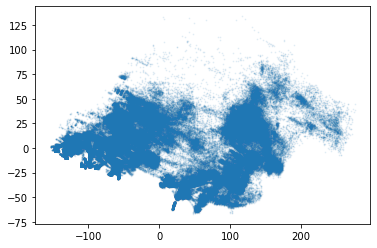

In [151]:
plt.scatter(X_r[:,0], X_r[:,1], s=.5, alpha=.1)

In [152]:
p = PCA(1)
X_r = p.fit(X).transform(X)
print('explained variance ratio (first two components): %s'
      % str(p.explained_variance_ratio_))
print(X_r.shape)

explained variance ratio (first two components): [0.91403927]
(300000, 1)


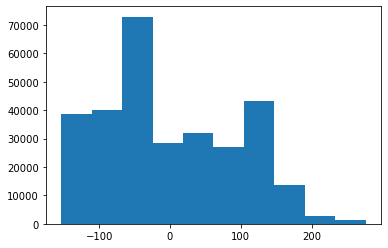

In [153]:
plt.hist(X_r[:,0])
min(raw_data[:,0])
max(raw_data[:,0])
xgt = raw_data[:,0] > 10
xlt = raw_data[:,0] < 11
xb = np.logical_and(xgt, xlt)
xslice = raw_data[xb]
len(xslice)
ylt = xslice[:,1] < 105
ygt = xslice[:,1] > 90
xyslice = xslice[np.logical_and(ygt, ygt)]

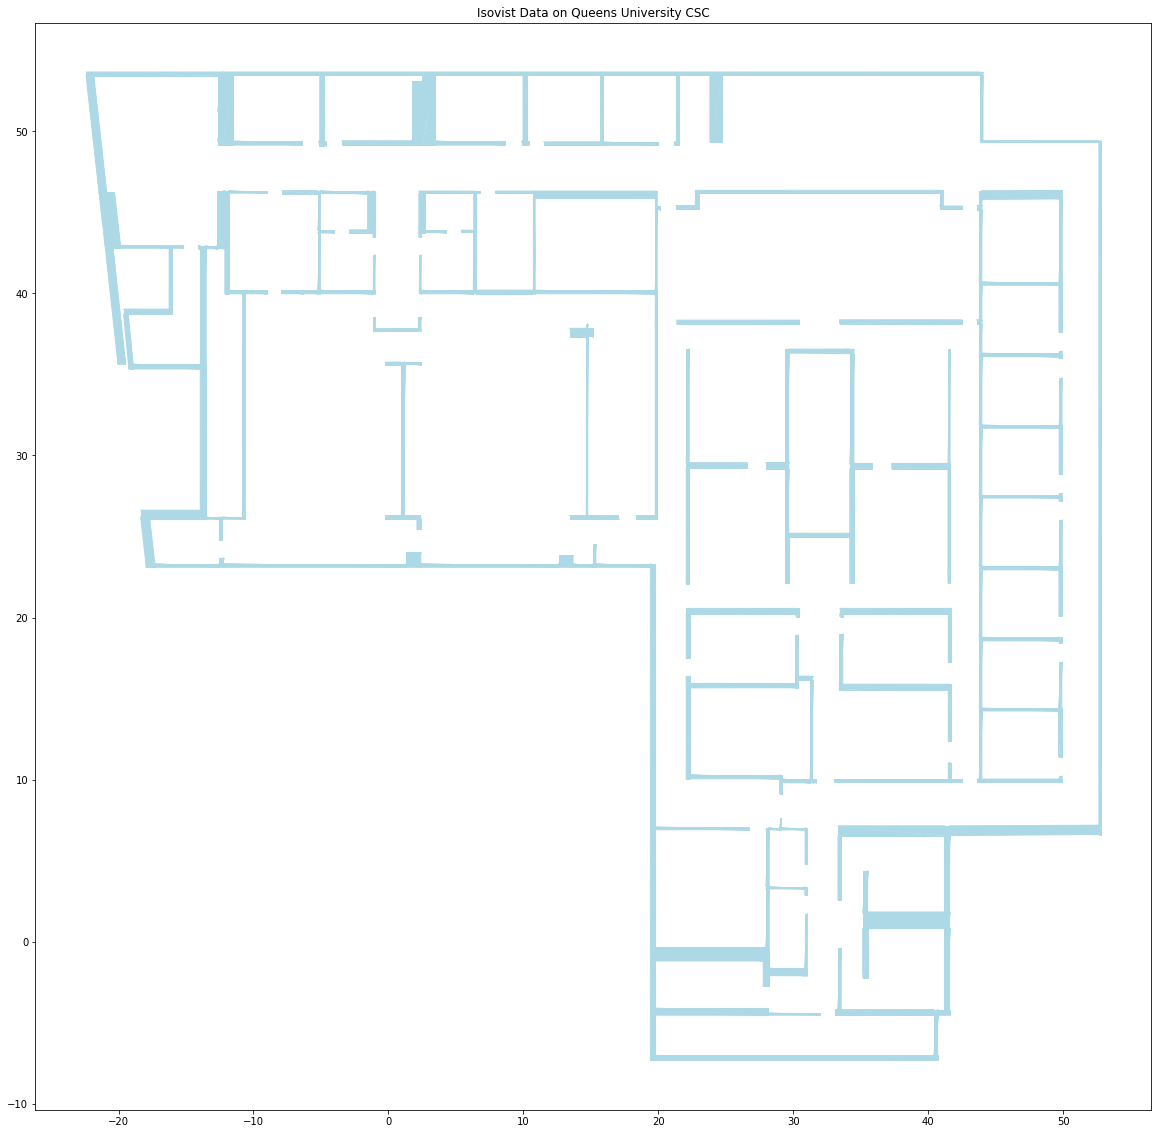

In [154]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_title('Isovist Data on {}'.format(maps['QueensU'].name))
maps['QueensU'].plot_map(ax)
ax.scatter(xyslice[:,0], xyslice[:,1], s=1, lw=0, label='trajectories', color='r')
#plot_equal(ax)

# Import Traclus Data

In [155]:

import json

#with open('output.json') as f:
#  data = json.load(f)

with open("output.txt", "rb") as fin:
    data = json.load(fin)

print(data[0])

trajectories = []
for traj in data:
    trajectory = []
    for point in traj:
        p = [float(point['x']), float(point['y'])]
        trajectory.append(p)
    trajectory = np.array(trajectory)
    trajectories.append(trajectory)
        
print(trajectories[0])
print(len(trajectories))
trajectories= np.array(trajectories)

[{'y': 42.95, 'x': -14.379999999999999}, {'y': 42.49999999999999, 'x': -14.530000000000001}, {'y': 42.38761715296198, 'x': -14.563258178603007}, {'y': 42.28000000000001, 'x': -14.600000000000001}, {'y': 42.26866657118305, 'x': -14.601823259810944}, {'y': 41.833228301346324, 'x': -14.735585792036666}, {'y': 41.610328947368416, 'x': -14.803223684210527}, {'y': 41.38, 'x': -14.890000000000002}]
[[-14.38        42.95      ]
 [-14.53        42.5       ]
 [-14.56325818  42.38761715]
 [-14.6         42.28      ]
 [-14.60182326  42.26866657]
 [-14.73558579  41.8332283 ]
 [-14.80322368  41.61032895]
 [-14.89        41.38      ]]
17


In [156]:
def saveplot(fig, filename='figure', folder='./plots_tmp', format='pdf', dpi=600, rasterized=False):
    try:
        os.makedirs(folder)
    except:
        pass
    
    target = os.path.join(folder,'{}.{}'.format(filename,format))
    print('Saving plot to {} ...'.format(target))
    fig.savefig(target, format=format, dpi=dpi, bbox_inches='tight', rasterized=rasterized)
    print('Done')

# Plot Paths

In [157]:
def plot_paths(map_):
    fig, ax = plt.subplots(figsize=(20,20))
    ax.set_title('Isovist Data on {}'.format(map_.name))
    map_.plot_map(ax)
    ax.scatter(map_.raw_data[:,0], map_.raw_data[:,1], s=1, lw=0, label='trajectories')
    #plot_equal(ax)
    
def plot_paths_lineplot(map_):
    fig, ax = plt.subplots(figsize=(20,20))
    #ax.set_title('Isovist Data on {}'.format(map_.name))
    map_.plot_map(ax)
    print(map_.raw_data[0])
    ax.plot(map_.raw_data[:,0], map_.raw_data[:,1], lw=.5, label='trajectories')
    # plot_equal(ax, legend_linewidth=1.5)
    for i in range(len(trajectories)):
        print(trajectories[i])
        print('Iteration: {}'.format(i))


        if trajectories[i].size < 1:
            continue
            
        if trajectories[i].size > 20:
            continue
            
        ax.plot(trajectories[i][:,0], trajectories[i][:,1], lw=2.5, c='red', label='Traclus')
   
    saveplot(fig,
             filename='paths_{}_numCluster{}_numPoints300000_lenTraj5'.format(map_.name, len(trajectories)),
             folder='./plots')
    
    
def plot_traclus(map_):
    fig, ax = plt.subplots(figsize=(20,20))
    map_.plot_map(ax)
    # ax.plot(trajectories)
    print(trajectories[0])
    for i in range(len(trajectories)):
        # print(trajectories[i])
        print('Iteration: {}'.format(i))


        if trajectories[i].size < 1:
            continue
            
        ax.plot(trajectories[i][:,0], trajectories[i][:,1], lw=1.5, c='red', label='Traclus')
    
    # ax.plot(trajectories[1][:,0], trajectories[1][:,1], lw=.5, c='red', label='Traclus')
    # ax.plot(trajectories[2][:,0], trajectories[2][:,1], lw=.5, c='red', label='Traclus')





# Plot Map and Trajectories

[24.        8.39     45.22762  30.62964  90.3245   17.13235   4.59796
  5.069654]
[[-14.38        42.95      ]
 [-14.53        42.5       ]
 [-14.56325818  42.38761715]
 [-14.6         42.28      ]
 [-14.60182326  42.26866657]
 [-14.73558579  41.8332283 ]
 [-14.80322368  41.61032895]
 [-14.89        41.38      ]]
Iteration: 0
[[-14.13  43.59]
 [-13.95  44.02]
 [-13.77  44.45]]
Iteration: 1
[[-11.45        46.83      ]
 [-11.10996294  46.8004254 ]
 [-11.10003792  46.79956473]
 [-10.99045499  46.79477675]
 [-10.54052732  46.75394634]
 [-10.52        46.75      ]
 [-10.17        46.72      ]]
Iteration: 2
[[ -9.84811779  30.72021937]
 [ -9.86093356  30.5998912 ]
 [ -9.86569205  30.58050208]
 [ -9.90005839  30.2599932 ]
 [ -9.90099056  30.24988455]
 [ -9.9028743   30.22966501]
 [ -9.91708973  30.12033918]
 [ -9.92684504  30.0303677 ]
 [ -9.94090484  29.88989454]
 [ -9.95659324  29.78039705]
 [ -9.96921811  29.66009113]
 [ -9.97036697  29.64995723]
 [ -9.98154126  29.53982037]
 [-10.0196139

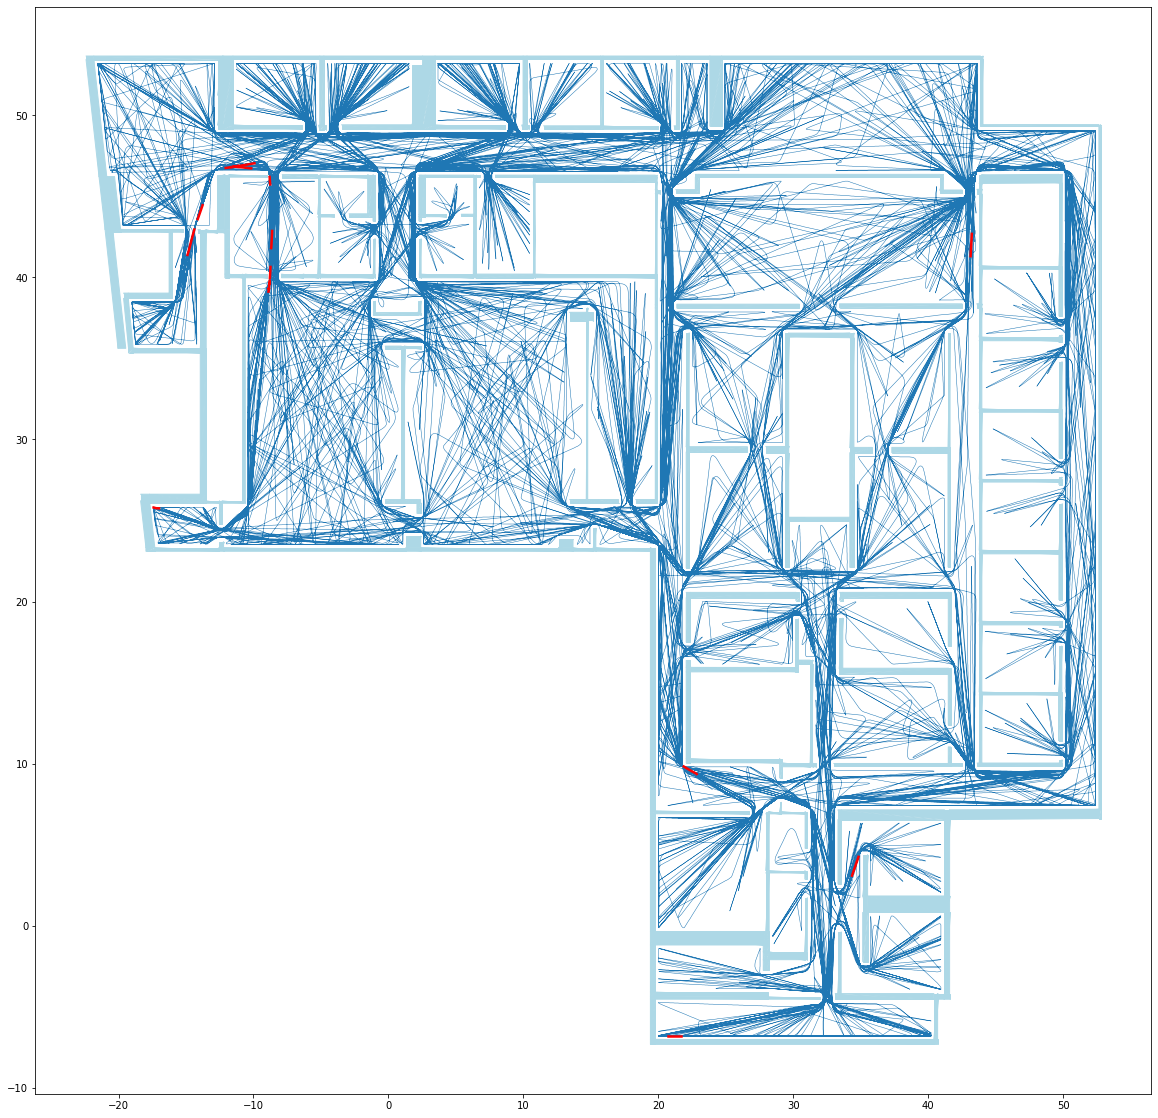

In [158]:
#print(trajectories)
for map_ in maps.values():
    plot_paths_lineplot(map_)
    # plot_traclus(map_)